# Import and Read

In [56]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [81]:
import math
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import xgboost as xgb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import randint
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [3]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

In [4]:
df.loc[8314:65671, 'Ebeam'] = 5.754

In [5]:
df['phi'] = df.phi.apply(lambda x: math.radians(x))

# Preprocessing (remove soft dups)

In [329]:
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

In [83]:
feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
label_data = df['dsigma_dOmega']

# Splitting Data into Train and Test

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
feature_data = scaler_feature.fit_transform(feature_data)
label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))

train_feature_data, test_feature_data, train_label_data, test_label_data = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)


# Creating Data Loaders
train_dataset = PhysicsDataSet(train_feature_data, train_label_data)
test_dataset = PhysicsDataSet(test_feature_data, test_label_data)

train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False)

# FCNN

In [75]:
# Creating a Data Set
class PhysicsDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

In [ ]:
input_dim = 5
hidden_dim_1 = 40
hidden_dim_2 = 40
hidden_dim_3 = 40
output_dim = 1

num_epochs = 10000
early_stop_cond = 0.00001
epoch_early_stop = 20

In [92]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim_1),
    nn.ReLU(),
    nn.Linear(hidden_dim_1, hidden_dim_2),
    nn.ReLU(),
    nn.Linear(hidden_dim_2, hidden_dim_3),
    nn.ReLU(),
    nn.Linear(hidden_dim_3, output_dim)
)

# Training the Model
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    train_loader = DataLoader(dataset = train_dataset, batch_size = 8, shuffle = True)
    for feature, label in train_loader:
        optimizer.zero_grad()
        outputs = model(feature.to(torch.float32))
        loss = criterion(outputs.to(torch.float32), label.to(torch.float32))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    if epoch > epoch_early_stop and abs(epoch_loss - last_loss) < early_stop_cond:
        break
    last_loss = epoch_loss

# Testing the Model
test_loss = 0.0
with torch.no_grad():
    for feature, label in test_loader:
        outputs = model(feature)
        loss = criterion(outputs, label)
        test_loss += loss.item()

print('Test Loss: {:.4f}'.format(test_loss))

In [103]:
df[['Ebeam', 'W', 'Q2', 'cos_theta']]

,Ebeam,W,Q2,cos_theta
0,1.515,1.11,0.3,0.991445
1,1.515,1.11,0.3,0.991445
2,1.515,1.11,0.3,0.991445
3,1.515,1.11,0.3,0.991445
4,1.515,1.11,0.3,0.991445
...,...,...,...,...
98022,5.499,2.01,4.0,0.975000
98023,5.499,2.01,4.0,0.975000
98024,5.499,2.01,4.0,0.975000
98025,5.499,2.01,4.0,0.975000


In [112]:
with torch.no_grad():
    scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']])).to(torch.float32)))

# Same but 20 examples 

In [113]:
def rundom_example_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        dsigma_dOmega_predicted = scaler_target.inverse_transform(model(torch.tensor(scaler_feature.transform(df_example_set_for_prediction)).to(torch.float32)))
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label='real_data')
    plt.legend()
    plt.show()

a = 0.760035416676811 , b = 0.035286760822596436, c = -0.41762889935339464


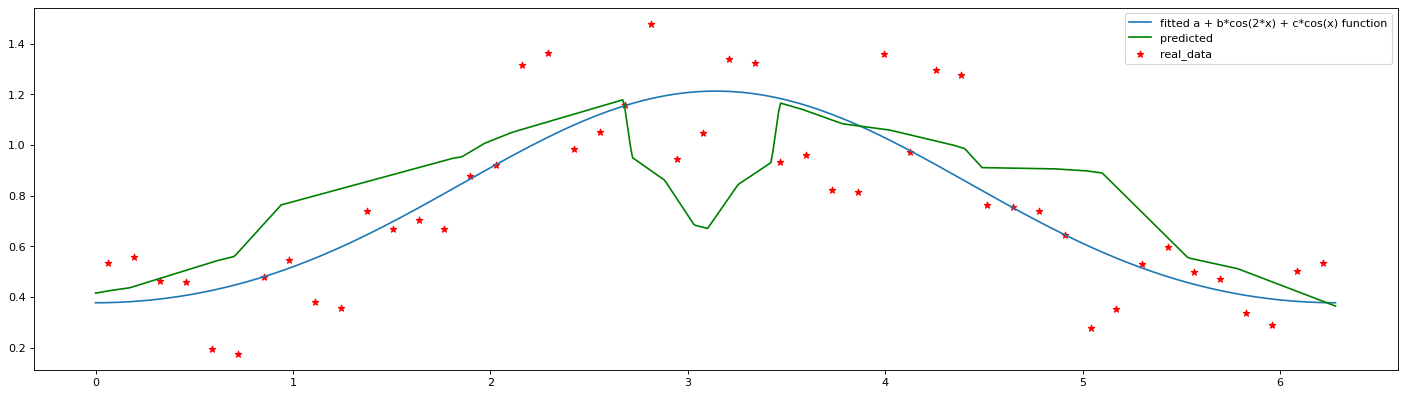

a = 0.8399979169757743 , b = 0.1504775089541308, c = 0.06371311246922817


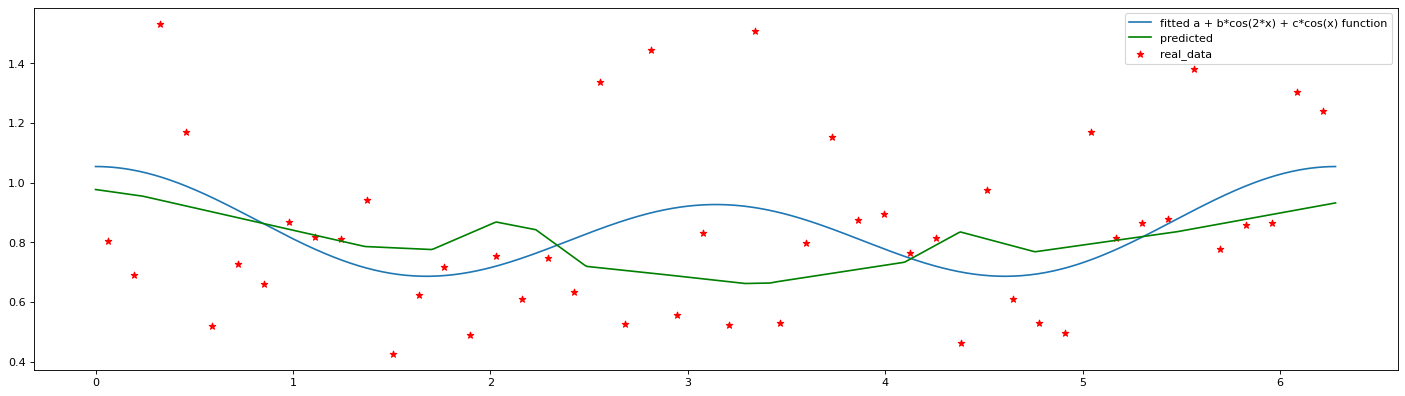

a = 0.11099672242961668 , b = -0.043499342494712365, c = -0.005796662930592663


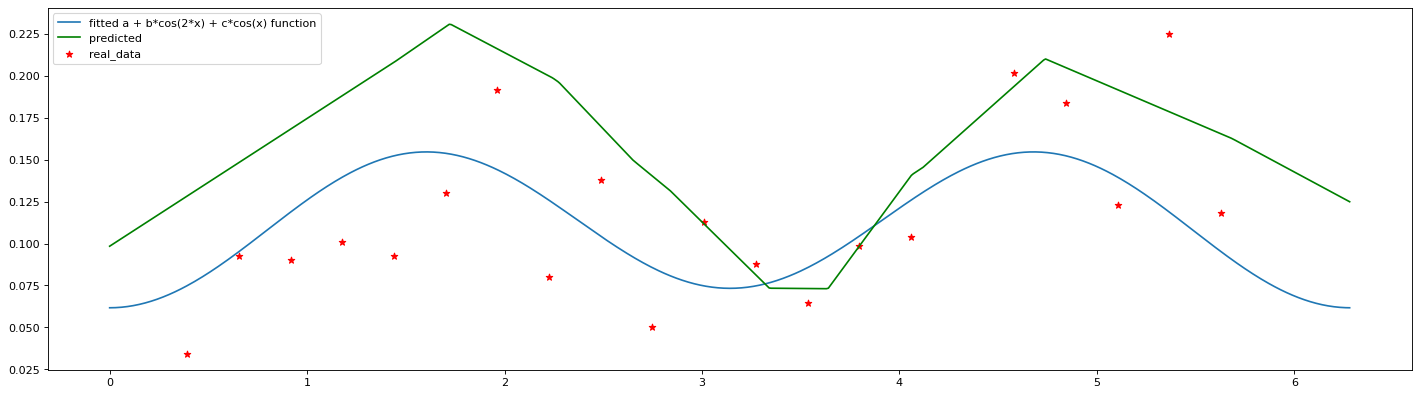

a = 0.3690995833333333 , b = -0.10277663201091043, c = 0.03012641323100314


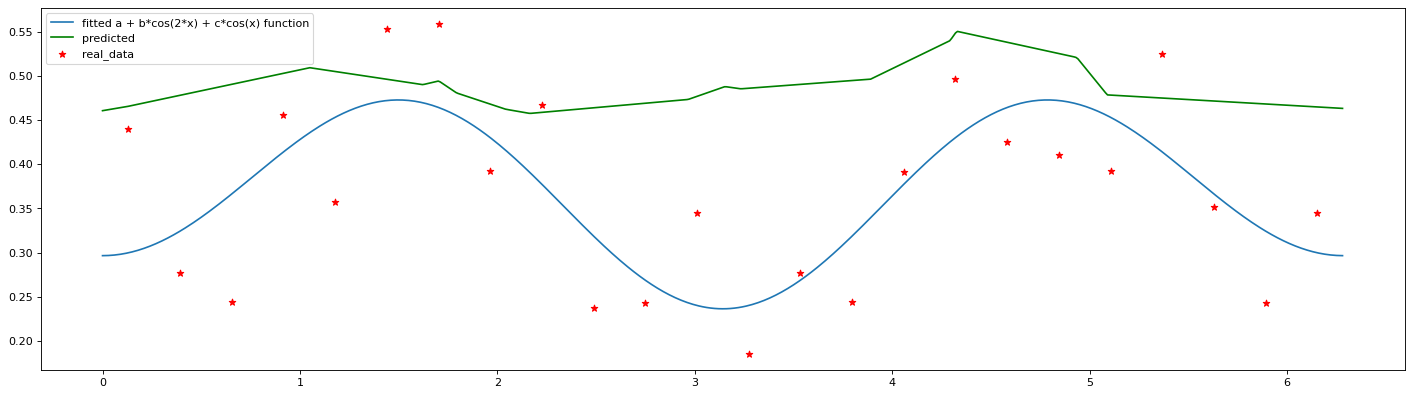

a = 0.7320897090439257 , b = -0.036142454100285736, c = -0.20244925209230163


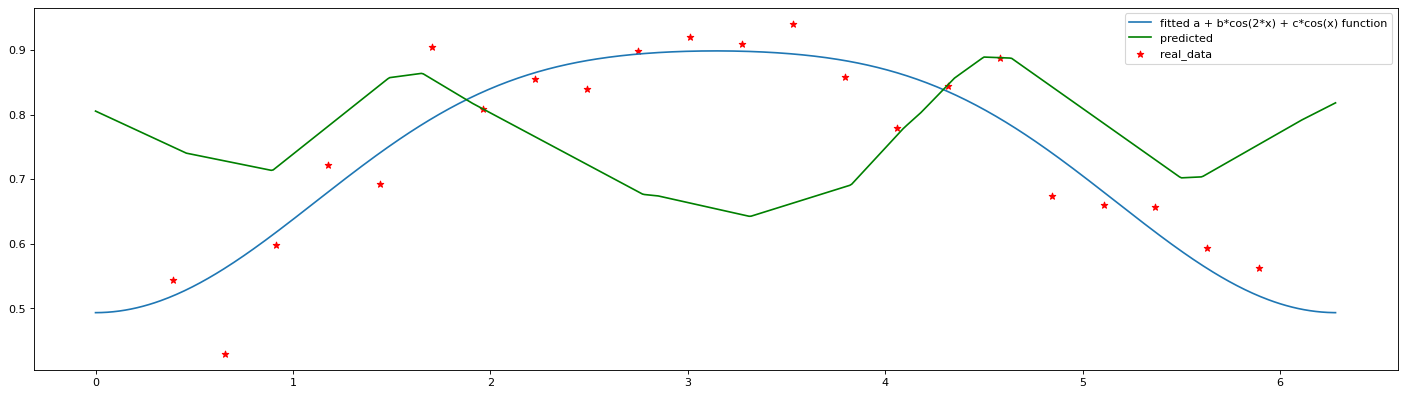

a = 0.23382770794316274 , b = -0.054939032178912085, c = 0.04081767005210999


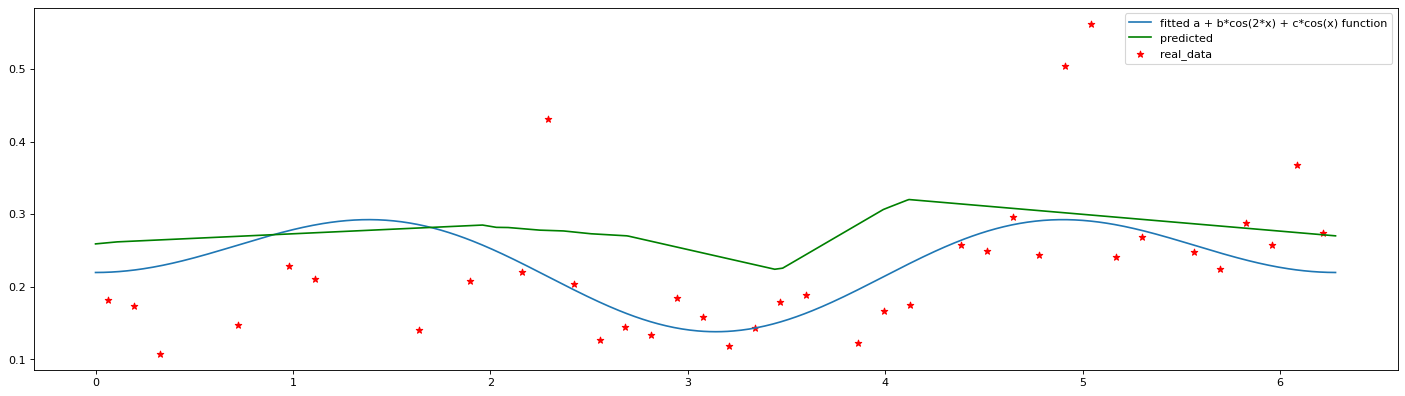

a = 0.2727134442298849 , b = -0.09217242188336962, c = -0.06802063042067777


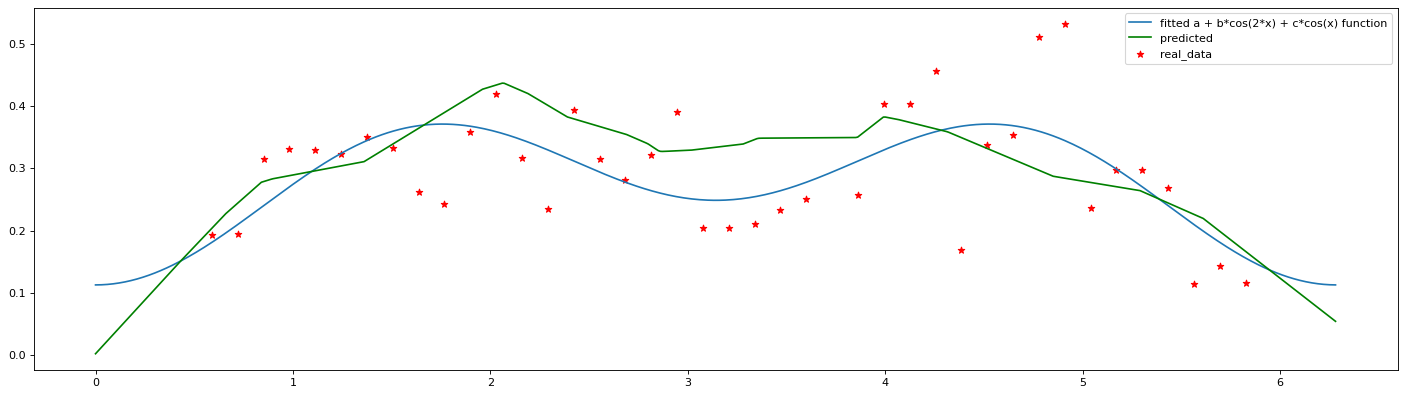

a = 4.358833335161631 , b = -1.380031726240855, c = 0.7676822802074149


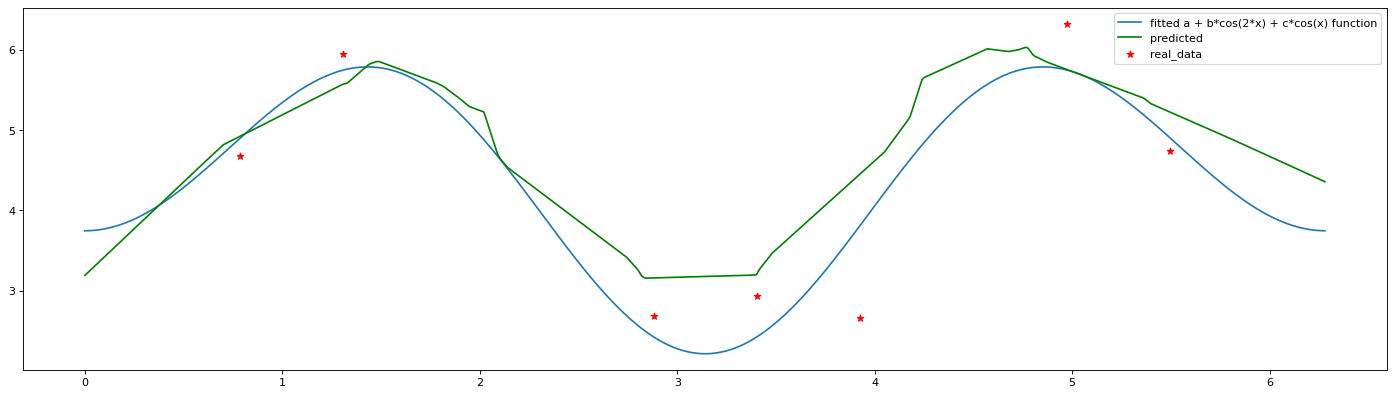

a = 1.1885720833333333 , b = -0.3326173054858741, c = -0.09081560461419577


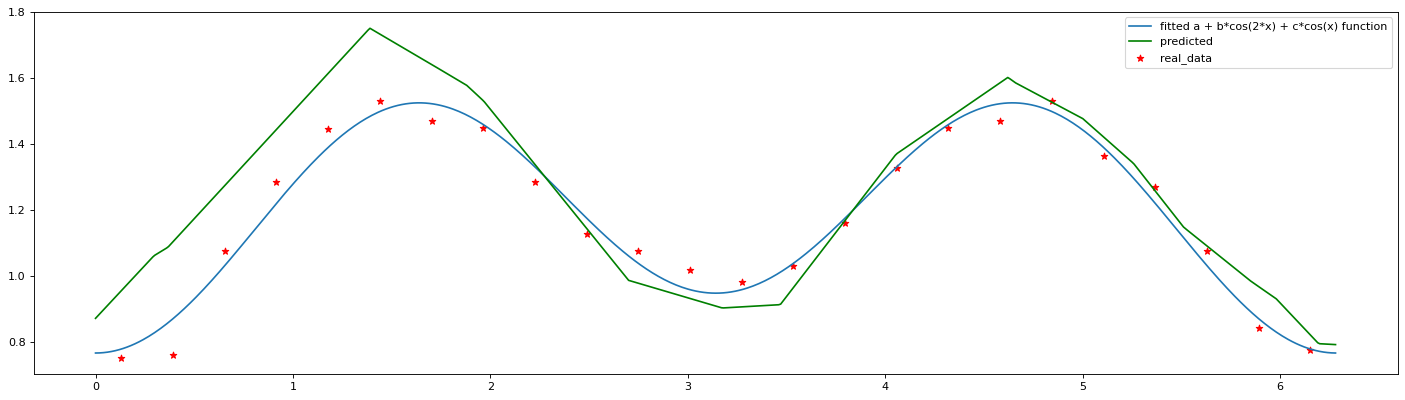

a = 0.9765000001883599 , b = -0.5900808412086057, c = -0.14885365786823104


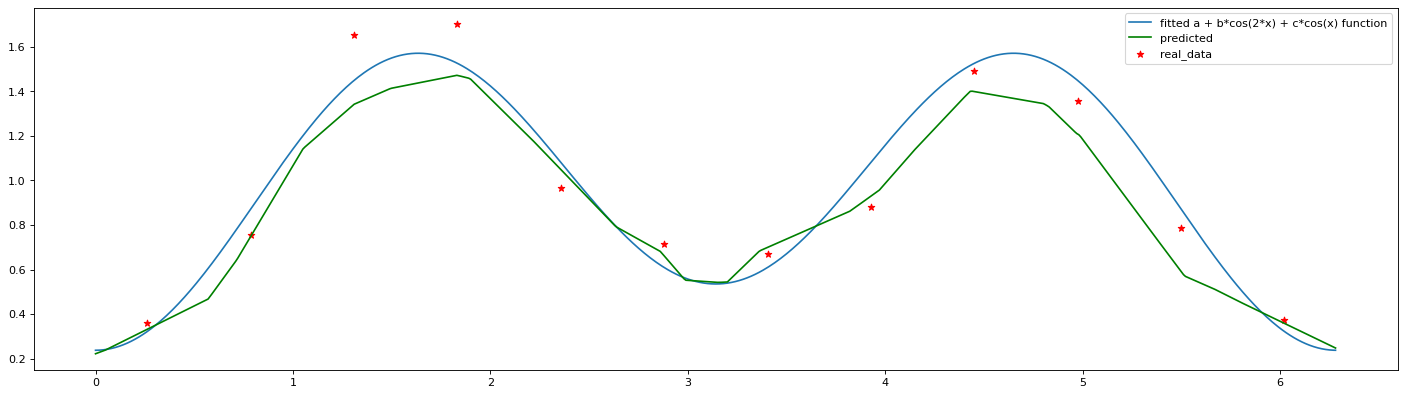

a = 0.7202999998459952 , b = -0.199488952047863, c = 0.2489577715536398


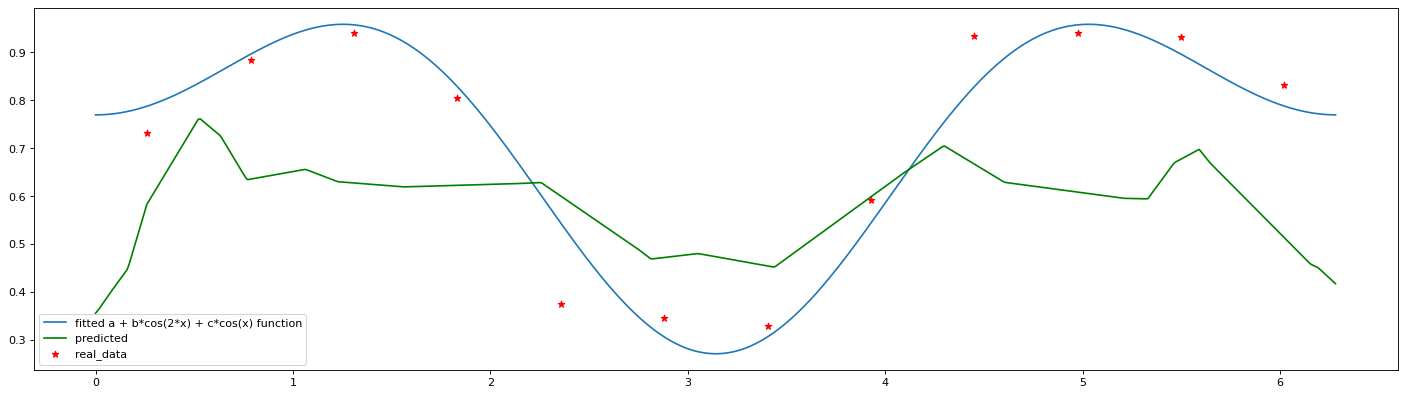

a = 0.45985745625052304 , b = -0.220443364565323, c = 0.06041893251965157


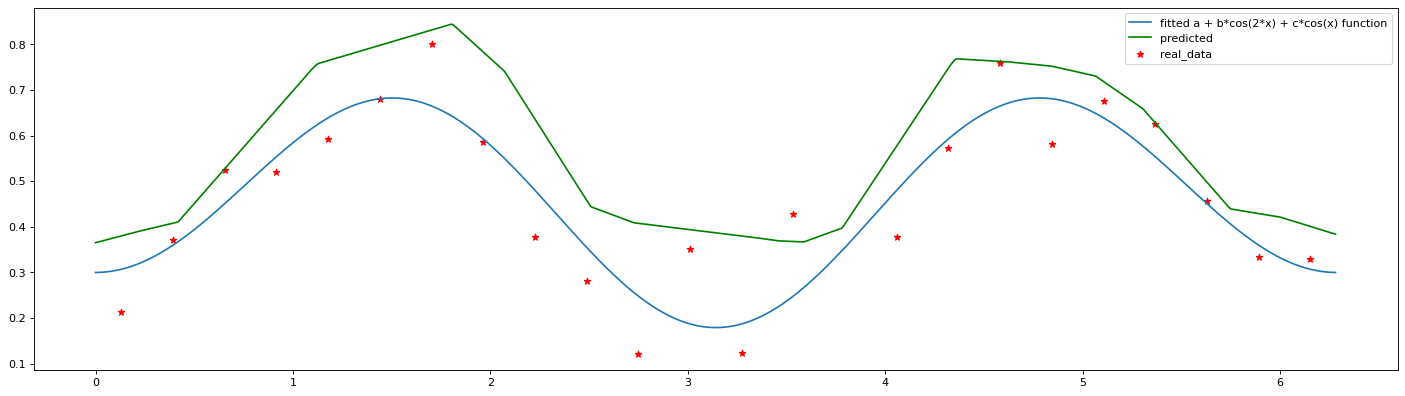

a = 0.16612374597683507 , b = -0.005280918467842092, c = 0.03700943960650912


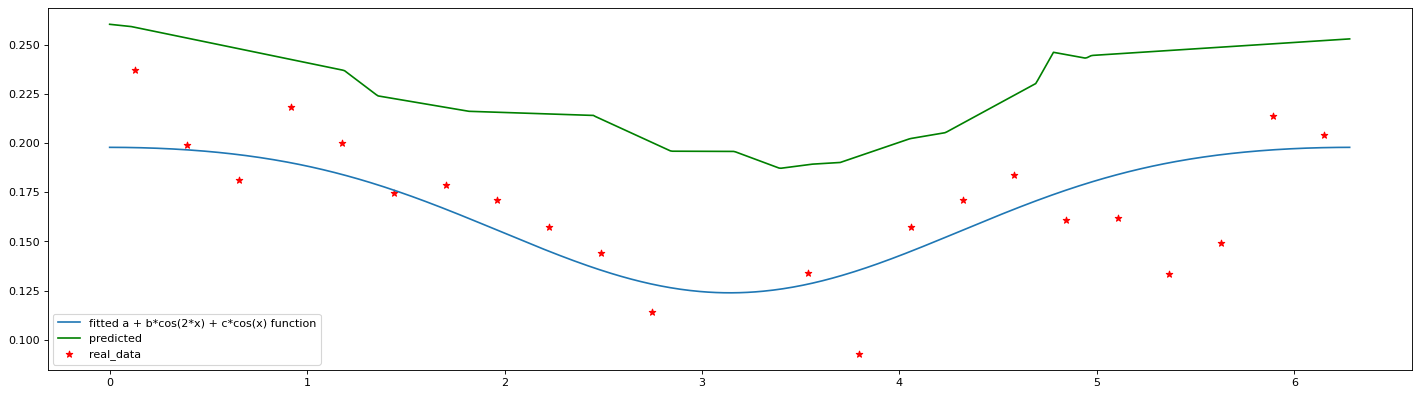

a = 1.9077500077215956 , b = -0.6375390535400209, c = 0.019474200069609315


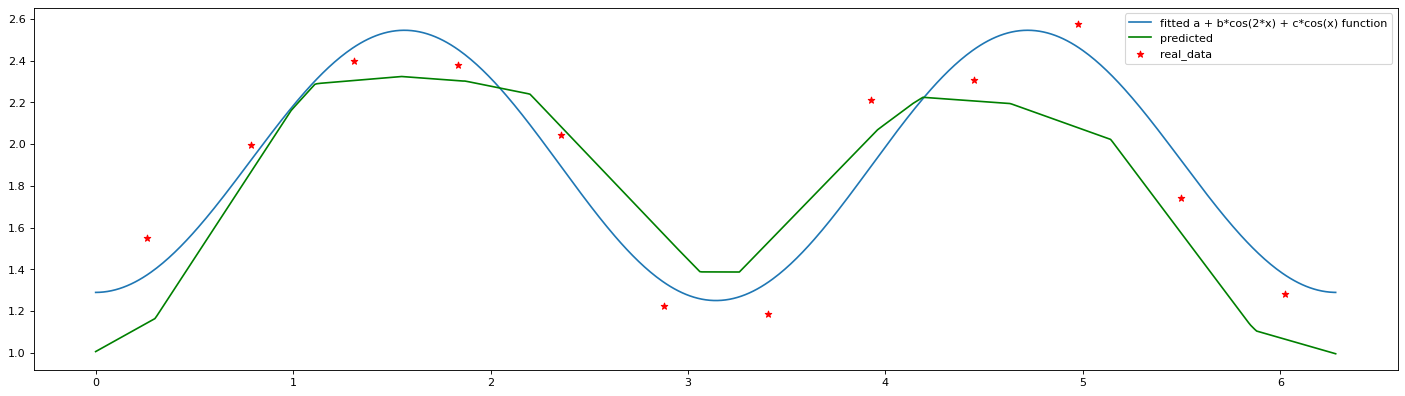

a = 1.6635550626806912 , b = -0.7796147534250764, c = -0.1401925387810239


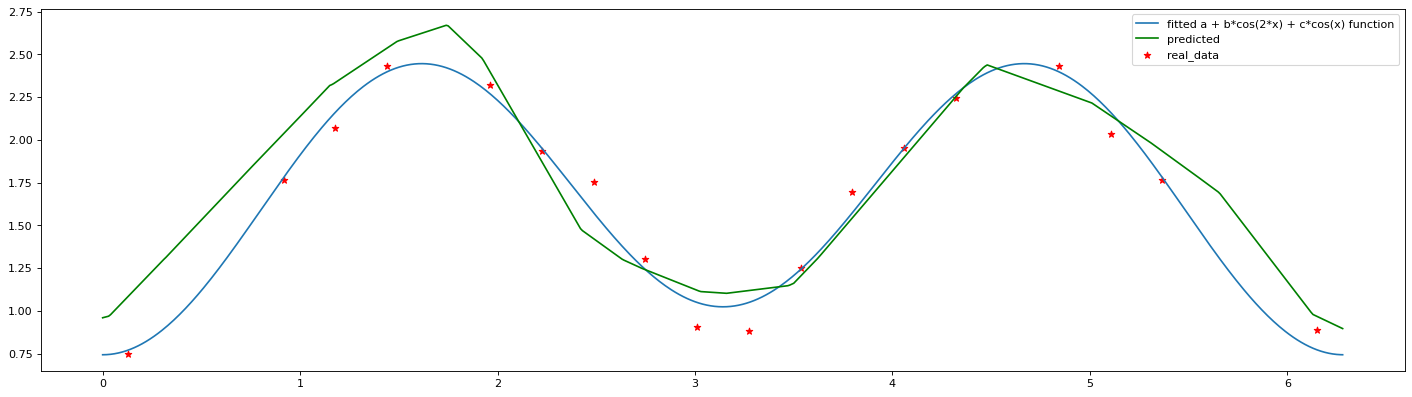

a = 0.3772895833333333 , b = -0.0865115398452008, c = 0.10435267506432579


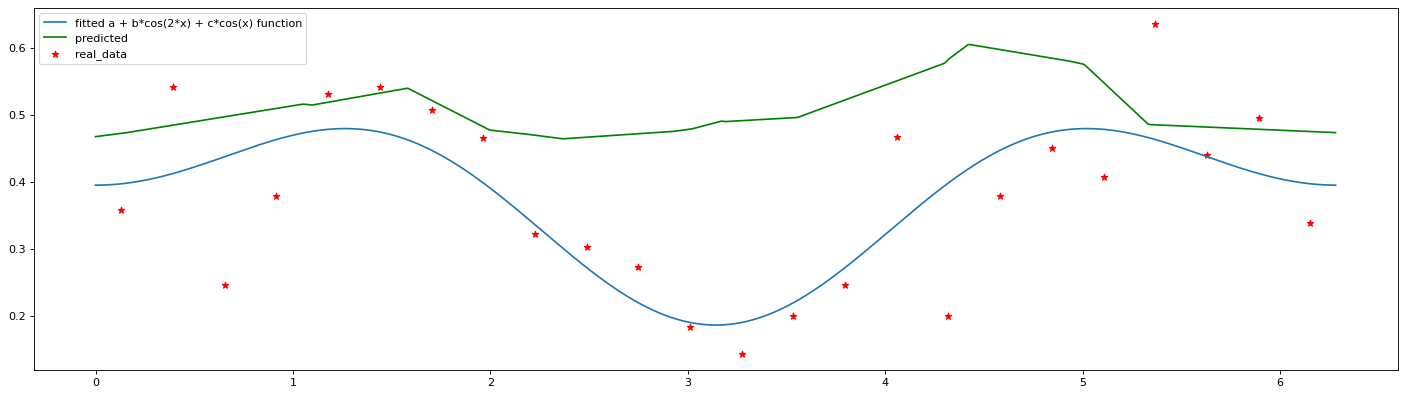

a = 0.8617983424244103 , b = -0.21578942279911964, c = -0.3260514249147518


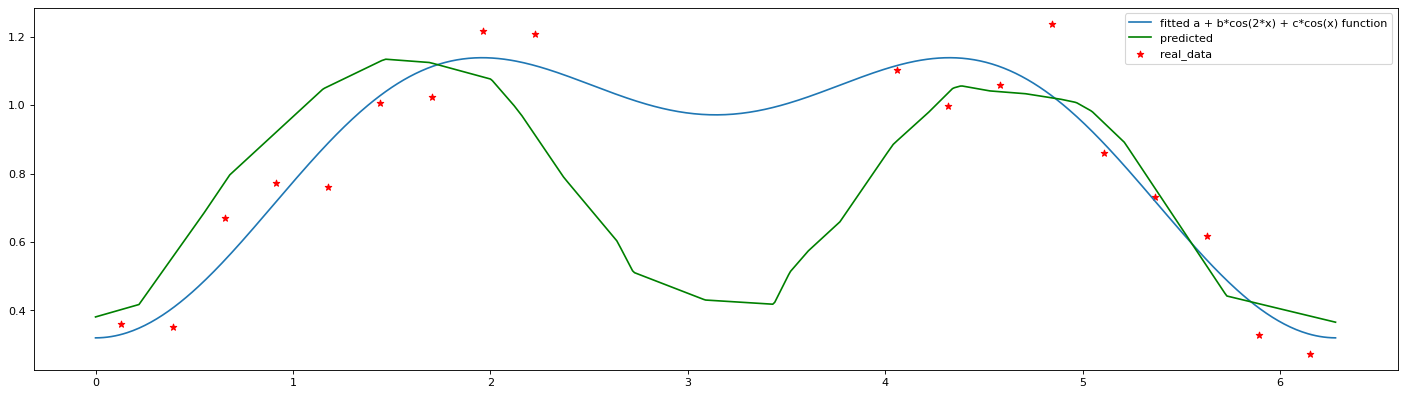

a = 0.46177500000000005 , b = -0.07551388333382393, c = -0.03381522043165216


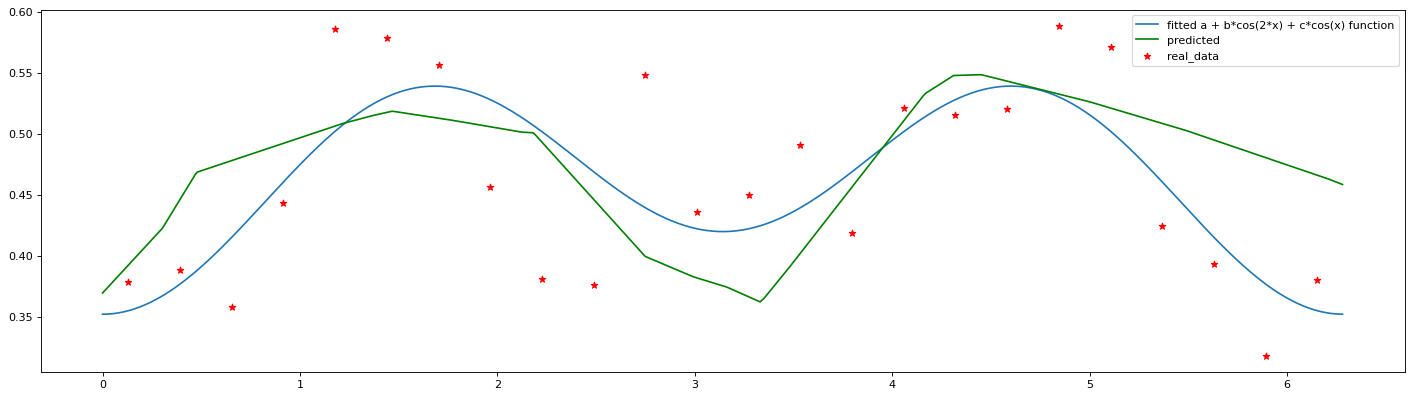

a = 0.35414004312307373 , b = 0.15197913444752825, c = 0.23447399542672942


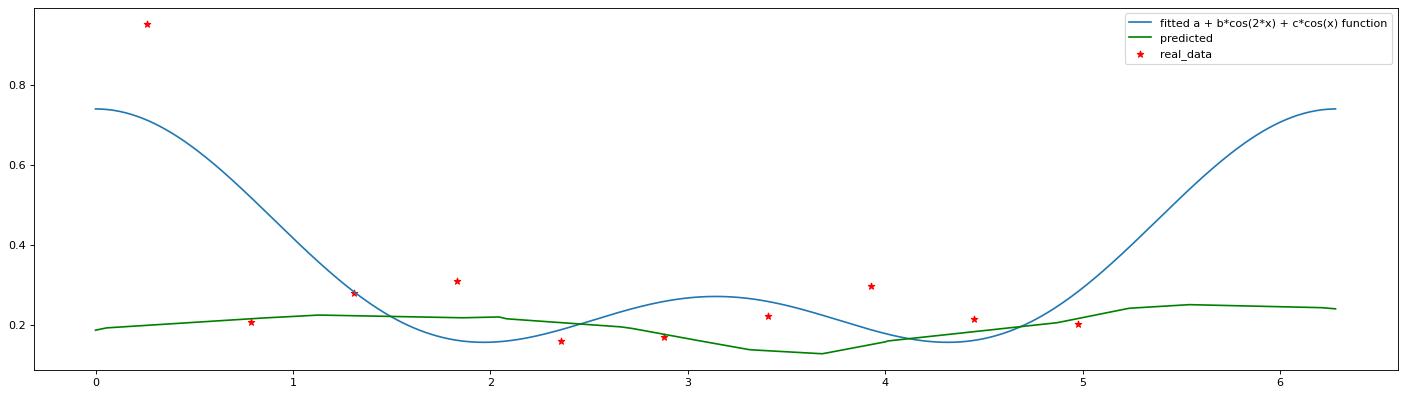

In [114]:
for i in range(1,20):
    rundom_example_check(df, randint(0, len(df)))